In [1]:
%load_ext autoreload
%autoreload 2
import sys
sys.path.insert(0, '../')

In [3]:

import matplotlib.transforms as mtransforms

import numpy as np
from biclus_viz import PlotCreator
from corset.rule import Rule
from corset.data import Dataset

from matplotlib import pyplot as plt
from corset.utils import makedir

In [6]:
from viz_utils import set_mpl_style
    
set_mpl_style()    

In [7]:
ds_name = 'bibtex'

In [9]:
ds = Dataset(name=ds_name, datadir='../data')
ds.load()

In [10]:
X_csc, Y_csc = ds.trn_X.tocsc(), ds.trn_Y.tocsc()

In [11]:
rules_raw = [
#     (('identification', 'communities'), ('TAG_network', 'TAG_community')), 
#     (('identification', 'communities'), ('TAG_socialnets', )),
#     (('identification', 'communities'), ('TAG_sna', )),
    (('identification', 'communities'), ('TAG_network', 'TAG_community', 'TAG_socialnets', 'TAG_sna')),     
    (('region', 'genome'), ('TAG_data', 'TAG_analysis')),
    (('connected', 'simultaneously'), ('TAG_topic11', 'TAG_network')),
    (('network', 'situations'), ('TAG_network', )),
    (('argued', 'social'), ('TAG_social', )),
    (('modeled', 'latent'), ('TAG_socialnets', )),
]
rules = []
for head_raw, tail_raw in rules_raw:
    head = tuple(ds.feature2id[feature_name] for feature_name in head_raw)
    tail = tuple(ds.label2id[label_name] for label_name in tail_raw)
    rule = Rule(head, tail)
    rule.bind_dataset(X_csc, Y_csc)
    rules.append(rule)

In [12]:
for r in rules:
    print(r.summary())

Rule(|H|=2, |L|=4, |supp|=3, area=12, p=1.00, q=0.00)
Rule(|H|=2, |L|=2, |supp|=3, area=6, p=1.00, q=0.00)
Rule(|H|=2, |L|=2, |supp|=2, area=4, p=1.00, q=0.00)
Rule(|H|=2, |L|=1, |supp|=5, area=5, p=0.83, q=0.02)
Rule(|H|=2, |L|=1, |supp|=5, area=5, p=0.83, q=0.03)
Rule(|H|=2, |L|=1, |supp|=3, area=3, p=1.00, q=0.01)


In [13]:
row_clusters = [list(r.support) for r in rules]
L_col_clusters = [list(r.tail) for r in rules]
F_col_clusters = [list(r.head) for r in rules]

In [14]:
def adjust_clusters(clusters):
    covered_idx = set()
    for idx in clusters:
        covered_idx |= set(idx)
    covered_idx = list(sorted(covered_idx))
    
    id_old2new = {old_id: new_id for new_id, old_id in enumerate(covered_idx)}
    id_new2old = {new_id: old_id for new_id, old_id in enumerate(covered_idx)}
    
    adjusted_clusters = []
    for clus in clusters:
        adjusted_clus = []
        for old_id in clus:
            adjusted_clus.append(id_old2new[old_id])
        adjusted_clusters.append(adjusted_clus)

    return covered_idx, adjusted_clusters, id_old2new, id_new2old

In [15]:
# extract sub submatrices whose rows and cols are covered by the rules
L = ds.trn_Y.todense()
F = ds.trn_X.todense()

covered_rows, row_clusters_adjusted, _, _ = adjust_clusters(row_clusters)
covered_cols_L, col_clusters_L_adjusted, _, label_id_mapping = adjust_clusters(L_col_clusters)
covered_cols_F, col_clusters_F_adjusted, _, feature_id_mapping = adjust_clusters(F_col_clusters)
L_sub = L[covered_rows][:, covered_cols_L]
F_sub = F[covered_rows][:, covered_cols_F]


# visualizing the label matrix

In [16]:
def prettify_fig(fig, ax):
#     fig.tight_layout()

    ax.set_xticklabels([])
    ax.set_yticklabels([])
    ax.tick_params(
        axis="both",
        which="both",
        bottom=False,
        top=False,
        labelbottom=False,
        right=False,
        left=False,
        labelleft=False,
    )
    plt.setp(ax.spines.values(), color='#aaa')  # change frame color    

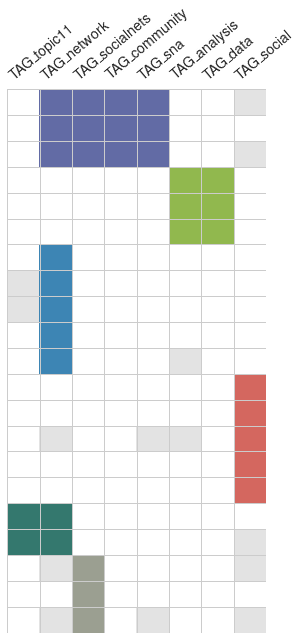

In [17]:
ordered_L_fig_path = "../plots/bicluster-viz/ordered-L.pdf"
bbm_L = PlotCreator.BlockBlockMatrix(row_clusters_adjusted, col_clusters_L_adjusted, L_sub)
bbm_L.order()
fig, ax = plt.subplots(1, 1, figsize=(5, 10))
bbm_L.plotMatrix(axs=ax, aspect=0.8, alpha=0.8)

prettify_fig(fig, ax)

ax.set_yticks(np.arange(F_sub.shape[0])-.51, va='top')

# map back to the correct label names (a bit involved though)
label_perm = bbm_L.getRightPermutation()
label_subset = [ds.label_names[label_id_mapping[label_perm[new_id]]] for new_id in range(len(label_id_mapping))]

ax.set_xticks(
    np.arange(len(label_subset)) - .5,
    # labels=list(map(lambda s: s[4:], label_subset)),  # remove "TAG_"
    labels=label_subset,
    rotation=40, ha='left')
ax.grid(which='major', c='#ccc')

fig.savefig(ordered_L_fig_path)



# visualizing the feature matrix

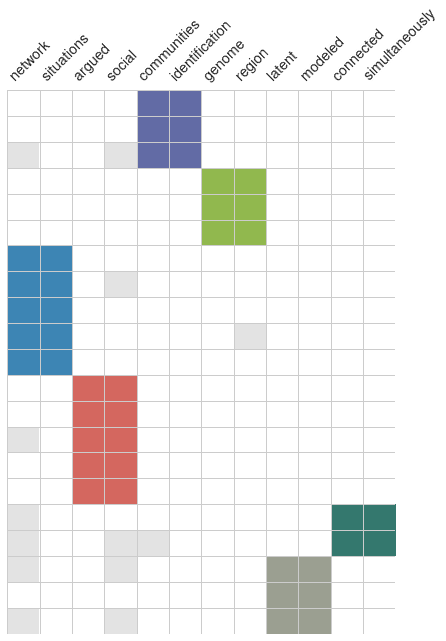

In [18]:
ordered_F_fig_path = "../plots/bicluster-viz/ordered-F.pdf"
bbm_F = PlotCreator.BlockBlockMatrix(row_clusters_adjusted, col_clusters_F_adjusted, F_sub)
bbm_F.order()
bbm_F.leftBlocksPermutation = bbm_L.leftBlocksPermutation  # bbm_F the row permutation inherits from bbm_L



fig, ax = plt.subplots(1, 1, figsize=(7, 10))
bbm_F.plotMatrix(axs=ax, aspect=0.8, alpha=.8)
prettify_fig(fig, ax)

# map back to the correct label names (a bit involved though)
feature_perm = bbm_F.getRightPermutation()
feature_subset = [ds.feature_names[feature_id_mapping[feature_perm[new_id]]] for new_id in range(len(feature_id_mapping))]


ax.set_yticks(np.arange(F_sub.shape[0])-.51, va='top')
ax.set_xticks(
    np.arange(len(feature_subset))-0.5,
    labels=feature_subset,
    rotation=45, ha='left')

ax.grid(which='major', c='#ccc')
fig.savefig(ordered_F_fig_path)




In [19]:
!pdfcrop ../plots/bicluster-viz/ordered-L.pdf ../plots/bicluster-viz/ordered-L.pdf
!pdfcrop ../plots/bicluster-viz/ordered-F.pdf ../plots/bicluster-viz/ordered-F.pdf

PDFCROP 1.40, 2020/06/06 - Copyright (c) 2002-2020 by Heiko Oberdiek, Oberdiek Package Support Group.
==> 1 page written on `../plots/bicluster-viz/ordered-L.pdf'.
PDFCROP 1.40, 2020/06/06 - Copyright (c) 2002-2020 by Heiko Oberdiek, Oberdiek Package Support Group.
==> 1 page written on `../plots/bicluster-viz/ordered-F.pdf'.
